In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch

import yaml
import os

# 参数设置

# 训练参数 
除了路径 其他不要变

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
args.to_save_path     = "../../../Run_logs"              
args.freq_save_path   = "../../../Freq_data"
args.window_save_path = "../../../Sliding_window"
args.root_path        = "../../../datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 256                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 150

args.learning_rate           = 0.001  
args.learning_rate_patience  = 5
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 1
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## 数据参数



In [3]:
args.seed                             = 1


args.data_name                        =  "pamap2"

args.wavelet_filtering                = False
args.wavelet_filtering_regularization = False
args.wavelet_filtering_finetuning     = False
args.wavelet_filtering_finetuning_percent = 0.5
args.wavelet_filtering_learnable      = False
args.wavelet_filtering_layernorm      = False

args.regulatization_tradeoff          = 0
args.number_wavelet_filtering         = 6


args.difference       =  False 
args.filtering        =  False
args.magnitude        =  False
args.weighted_sampler =  False




args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]

if args.difference:
    args.c_in = args.c_in*2

if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



## 模型参数

In [4]:
# args.filter_scaling_factor = 0.5
# args.model_type              = "deepconvlstm"#"tinyhar"#"sahar" #"deepconvlstm"

# # args.cross_channel_interaction_type = "attn"
# # args.cross_channel_aggregation_type = "filter"
# # args.temporal_info_interaction_type
# # args.temporal_info_aggregation_type

In [5]:
args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn" # attn  transformer  identity
args.cross_channel_aggregation_type = "filter"   # filter  naive  FC
args.temporal_info_interaction_type = "attn"  # gru  lstm  attn  transformer  identity
args.temporal_info_aggregation_type = "naive"   # naive  filter  FC 

# 实验

In [6]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = False
# exp = Exp(args)

In [7]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)

Use GPU: cuda:1
Build the TinyHAR model!
Done!
Parameter : 54543
Set the seed as :  1
 ----------------------- load all the data -------------------
----------------------- Get the Sliding Window -------------------
----------------------- Get the Sliding Window -------------------
================ LOCV Mode ====================
================ 9 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.00166945 0.00171527 0.00167224 0.00130208 0.00355872 0.0019802
 0.0017094  0.00273224 0.00311526 0.0018018  0.00131406 0.00793651]
Train data number :  6048
The number of classes is :  12
The input_length  is :  168
The channel_in is :  18
Validation data number :  672
Test data number :  5207
================ Build the model ================ 
Build the TinyHAR model!
Epoch: 1 cost time: 2.29713773727417
VALI: Epoch: 1, Steps: 24 | Train Loss: 2.1377285  Vali Loss: 1.9312986 Val

KeyboardInterrupt: 

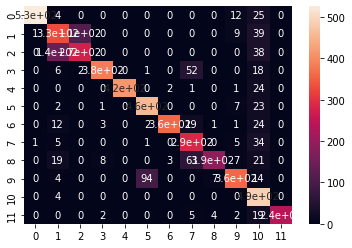

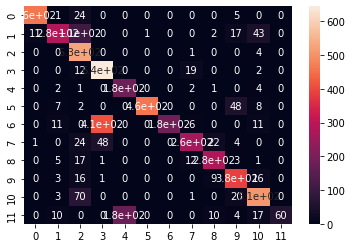

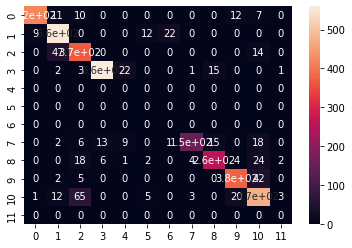

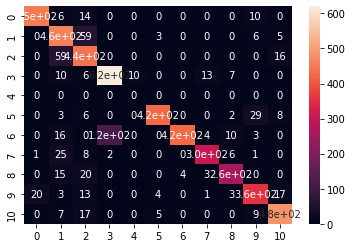

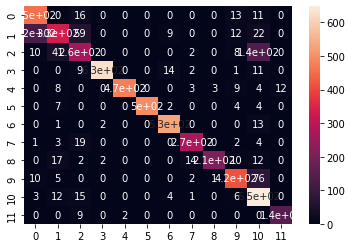

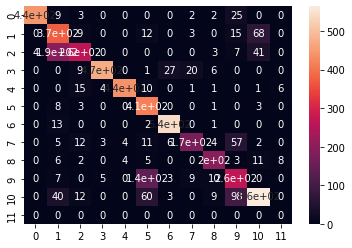

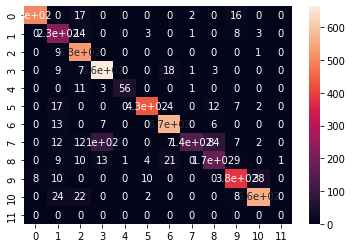

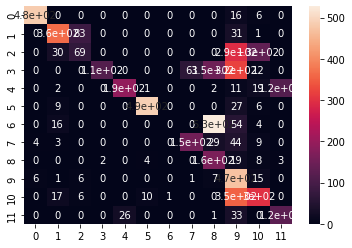

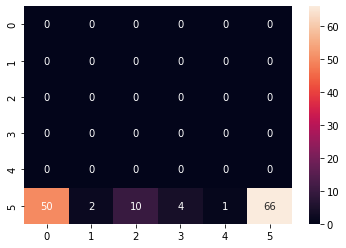

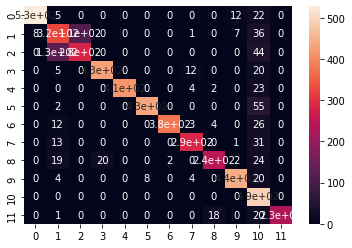

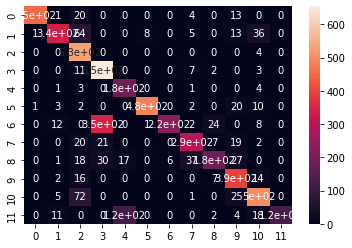

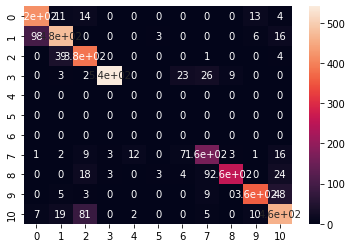

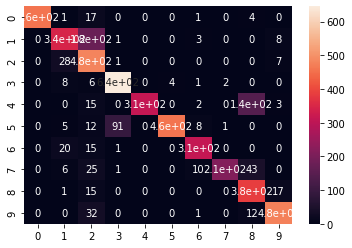

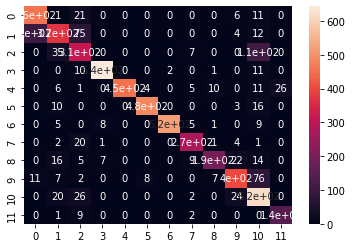

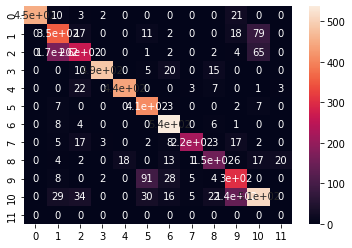

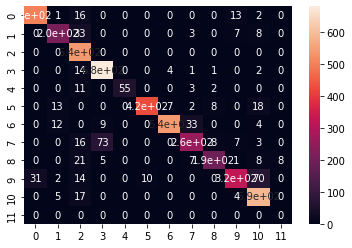

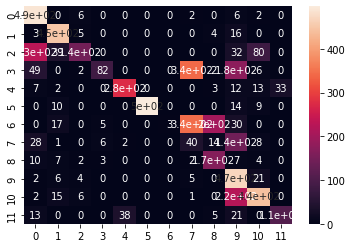

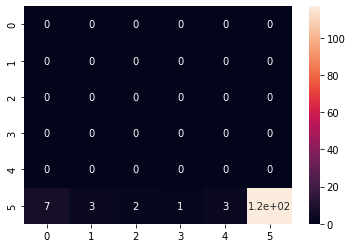

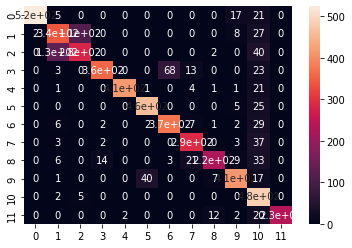

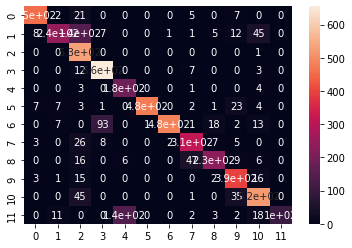

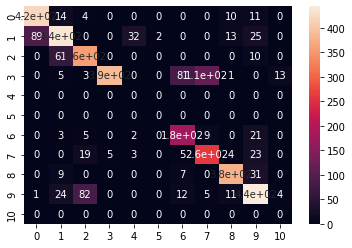

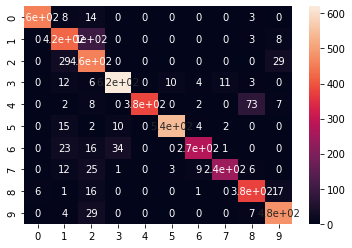

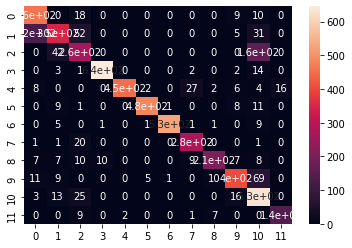

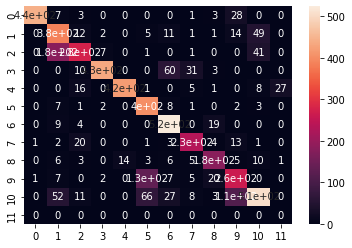

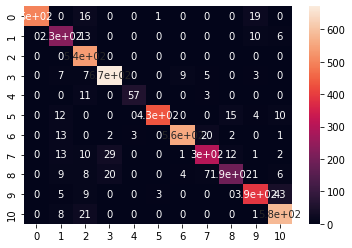

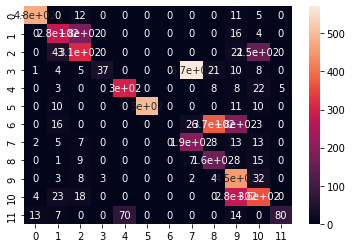

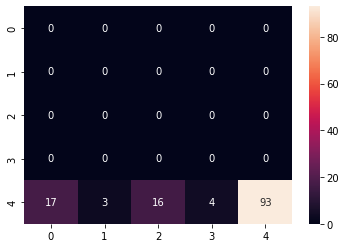

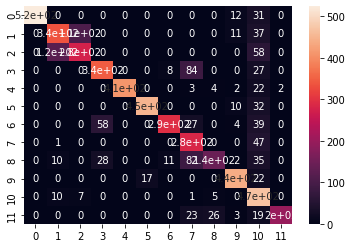

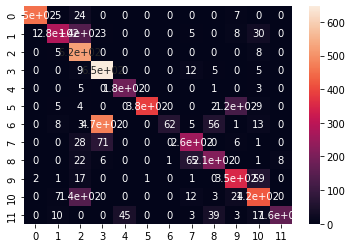

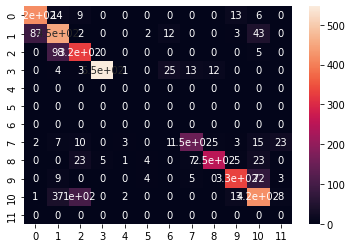

In [ ]:
for seed in range(1,6):
    args.seed=seed
    exp = Exp(args)
    exp.train()

In [6]:
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [7]:
import numpy as np

In [8]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).double().to(exp.device)
print(combined_x.shape)

torch.Size([2, 1, 128, 6])


In [9]:
out = exp.model(combined_x)
out = out.cpu().detach().numpy()

In [10]:
out.shape

(2, 31, 128, 6)

In [20]:
weight = exp.model.wave_conv.wavelet_conv.weight.cpu().detach().numpy()

In [18]:
for n,p in exp.model.named_parameters():
    print(n)

gamma
wave_conv.wavelet_conv.weight


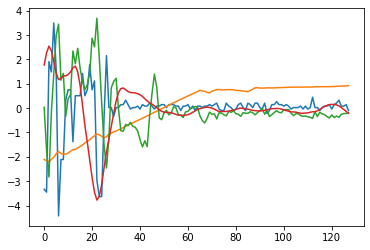

In [23]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0

plt.figure()
plt.plot(out[0,0,:,index2])
plt.plot(out[0,1,:,index2])
plt.plot(out[0,2,:,index2])
plt.plot(out[0,3,:,index2])

In [6]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)